# Takeaways
- Maintain separate payloads for api vs. mobile
    - Faster to read/write .parquet + .npy, but only api can use those
    - Mobile needs to use .sqlite + files (.png, .mp4), but it's slower for both read and write
- TODO Still more room to compress mobile payloads
    - 71% of payload: audio
        - Can be cut in ~half if we can drop 32k -> 16k (maybe with aac_he?)
            - Android supports HE-AACv2: https://developer.android.com/guide/topics/media/media-formats
            - But ios doesn't? https://apple.co/2NORQHB
        - Payload 1.98g -> ~1.28g -- ✅ ~35% of payload
    - 21% of payload: spectro
        - Not much excess: maybe ~5% of spectros (see notebooks/spectro_img_encode)
        - Payload 1.98g -> ~1.96g -- ❌ ~1% of payload
    - 5.9% of payload: f_preds_* sqlite cols (n_sp=331)
        - (Based on: 119m = 164m with - 45m without)
        - No float32 in sqlite, only float64 [❓ Unless we get clever and pack into int32/int16, or blob...]
            - [e.g. blob: https://github.com/SeanTater/sqlite3-extras]
        - Can pca compress, but can't achieve more than a few % of payload
        - Payload 1.98g -> ~1.98g with n_components=331 -- min ~0% of payload
        - Payload 1.98g -> ~1.93g with n_components=150 --  🔶 ~3% of payload
        - Payload 1.98g -> ~1.90g with n_components=100 --  🔶 ~4% of payload
        - Payload 1.98g -> ~1.86g with n_components=10  --  🔶 ~6% of payload
        - Payload 1.98g -> ~1.86g with n_components=0   -- max ~6% of payload
    - 2.2% of payload: rest of sqlite cols
        - Max ~2% of payload -- ❌ low ROI

In [ ]:
from notebooks import *
sg.init(None, skip=[sg_load.load_search_recs])
get_search_recs.cache_clear()

INFO     [11:48:27.386] [41798] 154 logging_/<module>: {logging_yaml: None}

INFO     [11:48:27.769] [41798]  36 api.server_globals/init

DEBUG    [11:48:27.776] [41798]  84 api.server_globals/load: load_search...

INFO     [11:48:28.309] [41798]  88 api.server_globals/load: load_search (took 0.526s)

DEBUG    [11:48:28.316] [41798]  84 api.server_globals/load: load_xc_meta...

INFO     [11:48:28.880] [41798]  88 api.server_globals/load: load_xc_meta (took 0.557s)

DEBUG    [11:48:28.888] [41798]  84 api.server_globals/load: load_feat_info...

INFO     [11:48:28.895] [41798] 120 api.server_globals/load_feat_info

INFO     [11:48:28.902] [41798]  88 api.server_globals/load: load_feat_info (took 0.007s)

WARNING  [11:48:28.907] [41798]  82 api.server_globals/load: load_search_recs [skipped]

INFO     [11:48:28.914] [41798]  38 api.server_globals/init: done

# Perf notes

Before
- Cold cache (warm pagecache but cold python proc)
```
search_recs(**{'cache_type': 'hybrid'})
...
DEBUG    [12:58:26.994] [37904] 119 payloads/df_cache_hybrid: Hit [start]
DEBUG    [12:58:27.001] [37904] 129 payloads/df_cache_hybrid: Hit: Reading non_feats.parquet (1.8 GB)
INFO     [12:58:32.028] [37904] 136 payloads/df_cache_hybrid: Hit: Read non_feats.parquet (1.8 GB)
DEBUG    [12:58:32.040] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-f_preds.npy (46.6 MB)
INFO     [12:58:32.077] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-f_preds.npy: float32 (46.6 MB)
DEBUG    [12:58:32.084] [37904] 141 payloads/df_cache_hybrid: Hit: Reading feat-feat.npy (211.4 MB)
INFO     [12:58:32.211] [37904] 143 payloads/df_cache_hybrid: Hit: Read feat-feat.npy: float32 (211.4 MB)
INFO     [12:58:32.218] [37904] 147 payloads/df_cache_hybrid: Hit: Join non_feats + feats
INFO     [12:58:32.469] [37904] 155 payloads/df_cache_hybrid: Hit [5.475s]
```

In [ ]:
# Fail if too few recs are downloaded (easy way to waste a bunch of training time!)
sg_load.load_xc_meta(_nocache=True,
    fail_on_low_download_frac=True,
);

INFO     [11:48:50.777] [41798] 104 api.server_globals/load_xc_meta

all              9442/399859 (sp/recs)

countries         1148/59713 (sp/recs)

species            774/52709 (sp/recs)

(downloaded)       774/52704 (sp/recs)

 99.99%

recs_at_least      774/52704 (sp/recs)

num_species        774/52704 (sp/recs)

num_recs           774/47367 (sp/recs)

recs ≥ 2           774/47367 (sp/recs)

search_recs(**{'cache_type': 'hybrid'})

INFO     [11:49:23.522] [41798] 602 api.recs/get_search_recs

INFO     [11:49:23.532] [41798] 152 payloads/df_cache_hybrid: Hit: payloads/search_recs-audio_s(10),version(8),com_names_k(us),countries_k(na),num_recs(200)-4a07700

INFO     [11:49:25.512] [41798] 169 payloads/df_cache_hybrid: Hit: Read api/lite.parquet (68.0 MB) [1.965s]

INFO     [11:49:35.786] [41798] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-audio_bytes.parquet (1.9 GB) [10.256s]

INFO     [11:49:36.815] [41798] 181 payloads/df_cache_hybrid: Hit: Read api/bytes-spectro_bytes.parquet (513.7 MB) [0.963s]

INFO     [11:49:36.938] [41798] 188 payloads/df_cache_hybrid: Hit: Read api/feat-f_preds.npy (139.8 MB) [float32, 0.109s]

INFO     [11:49:37.141] [41798] 188 payloads/df_cache_hybrid: Hit: Read api/feat-feat.npy (283.7 MB) [float32, 0.193s]

INFO     [11:49:37.148] [41798] 191 payloads/df_cache_hybrid: Hit: Join lite + bytes + feats

INFO     [11:49:37.692] [41798] 202 payloads/df_cache_hybrid: Hit [14.150s]

INFO     [11:49:41.677] [41798] 249 payloads/df_cache_hybrid: Mobile: Add columns for mobile [3.966s]

Mobile: Ensure dirs: audio_bytes: [

Mobile: Ensure dirs: audio_bytes: [

################################################################################

] | 100% (770) |  0.1s

Mobile: Write files: audio_bytes: [

Mobile: Write files: audio_bytes: [

Mobile: Write files: audio_bytes: [

Mobile: Write files: audio_bytes: [

Mobile: Write files: audio_bytes: [

Mobile: Write files: audio_bytes: [

####                                                                          

Mobile: Write files: audio_bytes: [

####                                                                          

Mobile: Write files: audio_bytes: [

####                                                                          

Mobile: Write files: audio_bytes: [

####                                                                          

Mobile: Write files: audio_bytes: [

######                                                                        

Mobile: Write files: audio_bytes: [

#########                                                                     

Mobile: Write files: audio_bytes: [

#########                                                                     

Mobile: Write files: audio_bytes: [

#########                                                                     

Mobile: Write files: audio_bytes: [

#########                                                                     

Mobile: Write files: audio_bytes: [

############                                                                  

Mobile: Write files: audio_bytes: [

#############                                                                 

Mobile: Write files: audio_bytes: [

#############                                                                 

Mobile: Write files: audio_bytes: [

#############                                                                 

Mobile: Write files: audio_bytes: [

##############                                                                

Mobile: Write files: audio_bytes: [

##################                                                            

Mobile: Write files: audio_bytes: [

##################                                                            

Mobile: Write files: audio_bytes: [

##################                                                            

Mobile: Write files: audio_bytes: [

##################                                                            

Mobile: Write files: audio_bytes: [

###################                                                           

Mobile: Write files: audio_bytes: [

######################                                                        

Mobile: Write files: audio_bytes: [

######################                                                        

Mobile: Write files: audio_bytes: [

######################                                                        

Mobile: Write files: audio_bytes: [

#######################                                                       

Mobile: Write files: audio_bytes: [

########################                                                      

Mobile: Write files: audio_bytes: [

###########################                                                   

Mobile: Write files: audio_bytes: [

###########################                                                   

Mobile: Write files: audio_bytes: [

############################                                                  

Mobile: Write files: audio_bytes: [

#############################                                                 

Mobile: Write files: audio_bytes: [

################################                                              

Mobile: Write files: audio_bytes: [

################################                                              

Mobile: Write files: audio_bytes: [

################################                                              

Mobile: Write files: audio_bytes: [

#################################                                             

Mobile: Write files: audio_bytes: [

####################################                                          

Mobile: Write files: audio_bytes: [

####################################                                          

Mobile: Write files: audio_bytes: [

#####################################                                         

Mobile: Write files: audio_bytes: [

######################################                                        

Mobile: Write files: audio_bytes: [

#########################################                                     

Mobile: Write files: audio_bytes: [

#########################################                                     

Mobile: Write files: audio_bytes: [

#########################################                                     

Mobile: Write files: audio_bytes: [

###########################################                                   

Mobile: Write files: audio_bytes: [

############################################                                  

Mobile: Write files: audio_bytes: [

############################################                                  

Mobile: Write files: audio_bytes: [

#############################################                                 

Mobile: Write files: audio_bytes: [

#############################################                                 

Mobile: Write files: audio_bytes: [

##############################################                                

Mobile: Write files: audio_bytes: [

###############################################                               

Mobile: Write files: audio_bytes: [

#################################################                             

Mobile: Write files: audio_bytes: [

#################################################                             

Mobile: Write files: audio_bytes: [

###################################################                           

Mobile: Write files: audio_bytes: [

###################################################                           

Mobile: Write files: audio_bytes: [

#####################################################                         

Mobile: Write files: audio_bytes: [

######################################################                        

Mobile: Write files: audio_bytes: [

#######################################################                       

Mobile: Write files: audio_bytes: [

#######################################################                       

Mobile: Write files: audio_bytes: [

########################################################                      

Mobile: Write files: audio_bytes: [

#########################################################                     

Mobile: Write files: audio_bytes: [

###########################################################                   

Mobile: Write files: audio_bytes: [

############################################################                  

Mobile: Write files: audio_bytes: [

############################################################                  

Mobile: Write files: audio_bytes: [

#############################################################                 

Mobile: Write files: audio_bytes: [

###############################################################               

Mobile: Write files: audio_bytes: [

################################################################              

Mobile: Write files: audio_bytes: [

################################################################              

Mobile: Write files: audio_bytes: [

#################################################################             

Mobile: Write files: audio_bytes: [

##################################################################            

Mobile: Write files: audio_bytes: [

####################################################################          

Mobile: Write files: audio_bytes: [

####################################################################          

Mobile: Write files: audio_bytes: [

####################################################################          

Mobile: Write files: audio_bytes: [

#####################################################################         

Mobile: Write files: audio_bytes: [

#####################################################################         

Mobile: Write files: audio_bytes: [

########################################################################      

Mobile: Write files: audio_bytes: [

########################################################################      

Mobile: Write files: audio_bytes: [

#########################################################################     

Mobile: Write files: audio_bytes: [

##########################################################################    

Mobile: Write files: audio_bytes: [

##############################################################################

] | 100% (47281) |  8.8s

Mobile: Ensure dirs: spectro_bytes: [

Mobile: Ensure dirs: spectro_bytes: [

##############################################################################

] | 100% (770) |  0.1s

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

Mobile: Write files: spectro_bytes: [

#######                                                                     

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###############                                                             

Mobile: Write files: spectro_bytes: [

###################                                                         

Mobile: Write files: spectro_bytes: [

############################                                                

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##############################                                              

Mobile: Write files: spectro_bytes: [

##################################                                          

Mobile: Write files: spectro_bytes: [

#########################################                                   

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

#############################################                               

Mobile: Write files: spectro_bytes: [

###############################################                             

Mobile: Write files: spectro_bytes: [

#####################################################                       

Mobile: Write files: spectro_bytes: [

##########################################################                  

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

############################################################                

Mobile: Write files: spectro_bytes: [

##############################################################              

Mobile: Write files: spectro_bytes: [

##############################################################              

Mobile: Write files: spectro_bytes: [

############################################################################

] | 100% (47281) |  8.7s

INFO     [11:50:35.760] [41798] 291 payloads/df_cache_hybrid: Mobile: Expand feat col: f_preds (739) [16.625s]

INFO     [11:50:36.584] [41798] 303 payloads/df_cache_hybrid: Mobile: Norm feat col: f_preds [0.806s]

INFO     [11:50:37.425] [41798] 334 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background) (47281) [0.217s]

INFO     [11:50:37.642] [41798] 334 payloads/<dictcomp>: Mobile: Covert non-sql col: json_dumps_canonical(background_species) (47281) [0.205s]

INFO     [11:51:38.769] [41798] 356 payloads/df_cache_hybrid: Mobile: Create table search_recs [402.9 MB, 60.851s]

INFO     [11:51:39.034] [41798] 393 payloads/df_cache_hybrid: Mobile: Create index (source_id) [823.3 kB, 0.249s]

INFO     [11:51:39.301] [41798] 393 payloads/df_cache_hybrid: Mobile: Create index (species, source_id) [1.1 MB, 0.256s]

INFO     [11:51:39.594] [41798] 393 payloads/df_cache_hybrid: Mobile: Create index (species, species_species_group, quality, source_id) [2.1 MB, 0.281s]

INFO     [11:51:39.898] [41798] 393 payloads/df_cache_hybrid: Mobile: Create index (species_species_group, species, quality, source_id) [2.1 MB, 0.290s]

INFO     [11:51:48.022] [41798] 399 payloads/df_cache_hybrid: Mobile: vacuum + analyze [8.113s]

INFO     [11:51:48.030] [41798] 401 payloads/df_cache_hybrid: Mobile: Write mobile-version(2)/search_recs/search_recs.sqlite3 [410.3 MB, 70.130s]

INFO     [11:51:48.043] [41798] 410 payloads/df_cache_hybrid: Mobile: Write mobile-version(2)/search_recs/server-config.json [2.3 kB, 0.002s]

INFO     [11:51:48.114] [41798] 441 payloads/df_cache_hybrid: Mobile: Write mobile-version(2)/search_recs/metadata/species.json [346.2 kB, 0.059s]

INFO     [11:51:48.225] [41798] 469 payloads/df_cache_hybrid: Mobile: Write mobile-version(2)/search_recs/metadata/xc_ids.json [938.0 kB, 0.099s]

INFO     [11:51:48.243] [41798] 490 payloads/_npy: Mobile: Write mobile-version(2)/search_recs/models/projection.skm_.D.npy [420.1 kB, 0.003s]

INFO     [11:51:48.256] [41798] 490 payloads/_npy: Mobile: Write mobile-version(2)/search_recs/models/projection.skm_.pca.mean_.npy [1.4 kB, 0.001s]

INFO     [11:51:48.268] [41798] 490 payloads/_npy: Mobile: Write mobile-version(2)/search_recs/models/projection.skm_.pca.components_.npy [134.5 kB, 0.001s]

INFO     [11:51:48.281] [41798] 490 payloads/_npy: Mobile: Write mobile-version(2)/search_recs/models/projection.skm_.pca.explained_variance_.npy [968 B, 0.001s]

INFO     [11:51:48.319] [41798] 490 payloads/_npy: Mobile: Write mobile-version(2)/search_recs/models/classifier_._coef_arr.npy [8.9 MB, 0.014s]

INFO     [11:51:48.335] [41798] 490 payloads/_npy: Mobile: Write mobile-version(2)/search_recs/models/classifier_._intercept_arr.npy [6.0 kB, 0.003s]

INFO     [11:51:48.342] [41798] 544 payloads/df_cache_hybrid: Mobile: Write mobile-version(2)/search_recs/models/search.json [9.8 kB, 0.106s]

INFO     [11:51:48.349] [41798] 544 payloads/df_cache_hybrid: Mobile: Write payload [130.643s]

,dir,file,size,frac
5,api,TOTAL,2897964675,1.000
1,api,api/bytes-audio_bytes.parquet,1892876617,0.653
2,api,api/bytes-spectro_bytes.parquet,513679265,0.177
4,api,api/feat-feat.npy: float32,283686128,0.098
3,api,api/feat-f_preds.npy: float32,139762764,0.048
0,api,api/lite.parquet,67959901,0.024
9,mobile-version(2),TOTAL,3028185088,1.000
6,mobile-version(2),mobile-version(2)/search_recs/audio/,2013802496,0.665
7,mobile-version(2),mobile-version(2)/search_recs/spectro/,604098560,0.199
8,mobile-version(2),mobile-version(2)/search_recs/search_recs.sqlite3,410284032,0.135


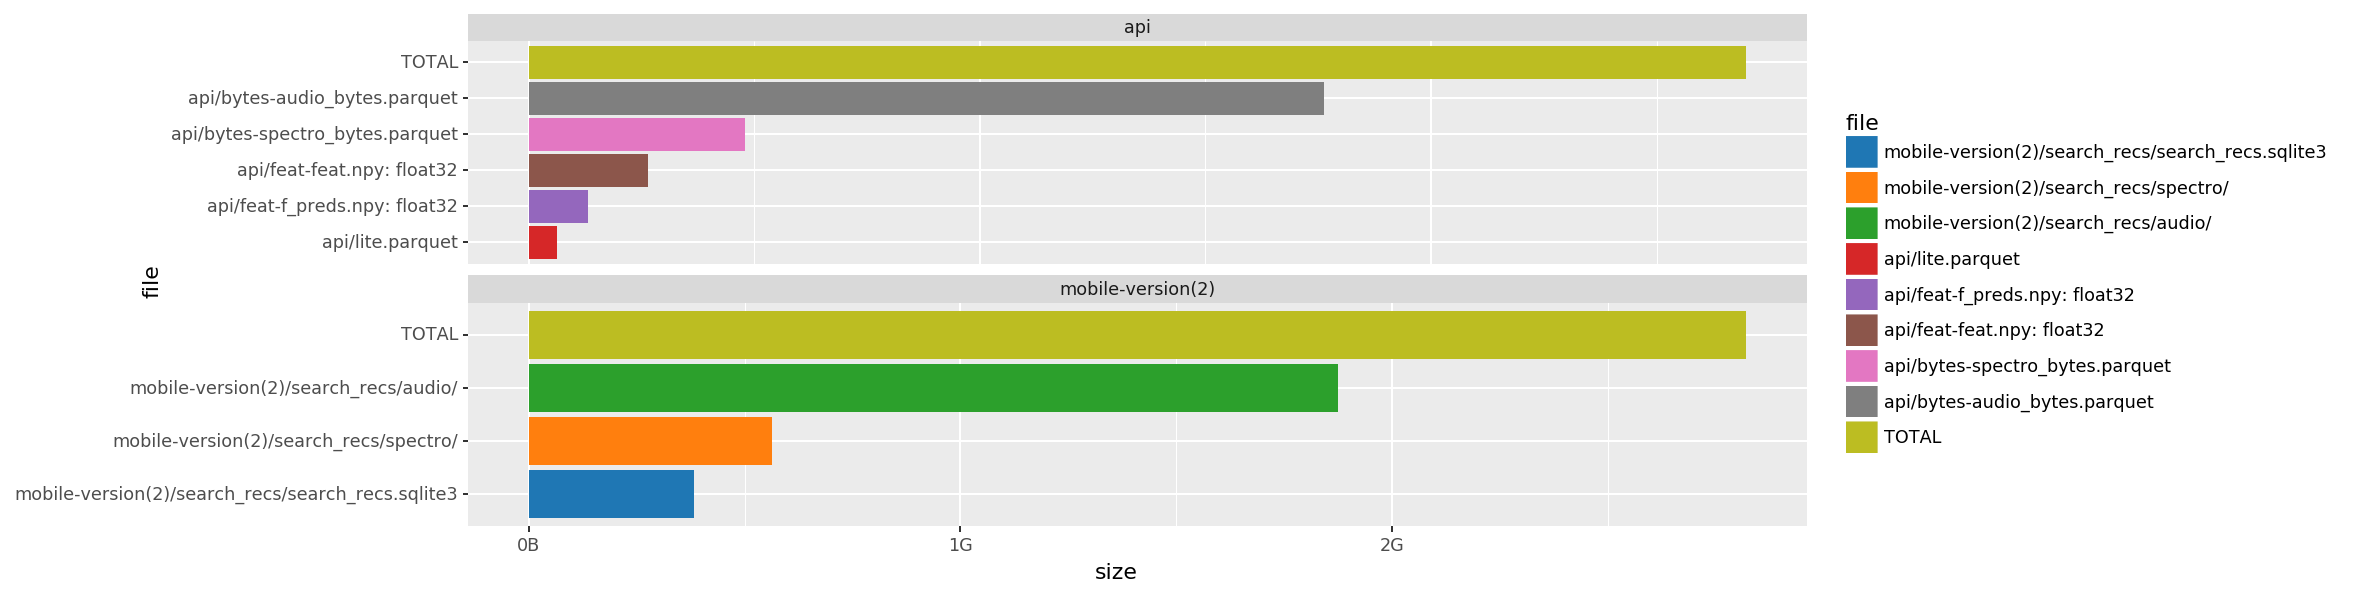

<ggplot: (-9223372036483391642)>

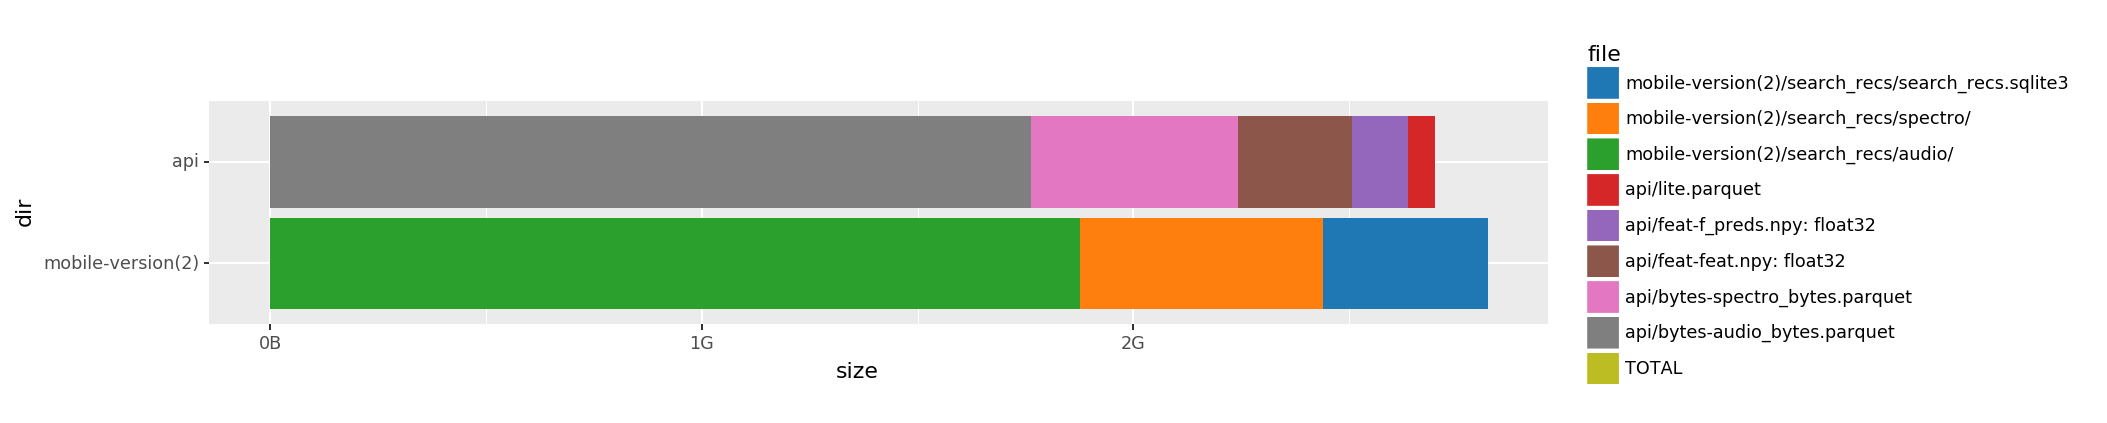

<ggplot: (472448576)>

,size,type,0
xc_id,36,int,172928
feat,104,ndarray,[ 8.224e-03 -3.858e-02 -8.680e-02 1.985e-02 4.682e-03 3.001e-02 2.210e-02 -2.915e-02 -9.975e-03 -1.798e-01 -2.439e-02 -1.525e-02 -9.203e-02 -4.123e-02 -1.084e-01 9.13...
f_preds,104,ndarray,[1.270e-06 8.470e-05 1.179e-04 2.203e-03 7.979e-09 2.603e-08 1.467e-06 6.317e-04 6.763e-06 1.072e-05 2.887e-03 1.570e-05 3.224e-04 6.562e-06 1.802e-06 2.199e-04 1.367e-04 ...
background,80,list,['Common Poorwill (Phalaenoptilus nuttallii)']
background_species,80,list,['COPO']


In [ ]:
with ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # XXX Debug
    log_levels({
        'payloads': 'INFO',
        # 'payloads': 'DEBUG',
    })
    kwargss = [
        # dict(cache_type='hybrid', refresh=True),  # Simulate cache miss [XXX Debug]
        dict(cache_type='hybrid'),                  # Allow cache hit
    ]
    search_recss = []
    for i, kwargs in enumerate(kwargss):
        if i > 0: print()
        print(f'search_recs(**{kwargs})')
        get_search_recs.cache_clear()
        search_recs = get_search_recs(**kwargs,
            write_mobile_payload=True,  # NOTE Comment out to write just api/ (not mobile-*/)
            plot_sizes=True,
        )
        search_recss.append(search_recs)
        display(search_recs
            [['xc_id', 'feat', 'f_preds', 'background', 'background_species']]
            [2:3].reset_index(drop=True).T
            .pipe(df_assign_first,
                size=lambda df: df.T.memory_usage(deep=True),
                type=lambda df: df[0].map(lambda x: type(x).__name__),
            )
        )

In [ ]:
# TODO Turn this into unit tests
#   - Should roundtrip, should preserve category dtypes, should fail if index present
assert len(search_recss) == 2, "Test requires both 'cache hit' + 'cache miss' to be uncommented (above)"
[a, b] = search_recss
pd.testing.assert_frame_equal(a, b, check_column_type=True,
    check_index_type=False,  # Allow Int64Index vs. RangeIndex
)

[skip]